In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
# !pip install -q wordcloud
import wordcloud
#Same as in assignment1, for preprocessing of text
!python -m spacy download el_core_news_lg
import spacy as sp#tokeniser, parser tagger for greek language
import unicodedata #character properties for all Unicode characters
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
!pip install greek-stemmer-pos
from greek_stemmer import stemmer
#-------------------------------------------------------------------------------------------
import torch
import torch.nn as nn #Base class for all neural network modules.
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets 
from gensim.models import Word2Vec
from sklearn.metrics import f1_score as skf1
from torchmetrics.functional import f1_score
#-------------------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from IPython.core.display import Path
import random
import os
os.environ['PYTHONHASHSEED'] = str(69)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.6/568.6 MB 2.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('el_core_news_lg')
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
  Obtaining dependency information for pytest-cov from https://files.pythonhosted.org/packages/a7/4b/8b78d126e275efa2379b1c2e09dc52cf70df16fc3b90613ef82531499d73/pytest_cov-4.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for coverage[toml]>=5.2.1 from https://files.pythonhosted.org/packages/94/1b/bd597a07755b233822760c9998d603218ca4b3151b6d5048e9fd0a5bf572/coverage-7.3.4-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.4/228.4 kB 7.9 MB/s eta 0:00:00


Reinitialize seed for random functions


In [2]:
#Reinitialize seed for random functions

def randreset(s):  #making sure each run will yield consistent results
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.cuda.manual_seed_all(s)



Load comptetion files

In [3]:
#hello there my name is jimmy#jsonpath1 = 'lem.json'
jsonpath2 = 'stem.json'
#jsonpath1 = '/kaggle/input/json-files/lem.json'
#jsonpath2 = '/kaggle/input/json-files/stem.json'
path = '/kaggle/input/ys19-2023-assignment-2/test_set.csv'
test_set = pd.read_csv(path) 
path = '/kaggle/input/ys19-2023-assignment-2/valid_set.csv'
valid_set = pd.read_csv(path) #4 columns id, text, sentiment, party
path = '/kaggle/input/ys19-2023-assignment-2/train_set.csv'
train_set = pd.read_csv(path)
#Making sure dataset is balanced
counts = train_set['Sentiment'].value_counts()
print(counts)


Sentiment
NEUTRAL     12210
NEGATIVE    12210
POSITIVE    12210
Name: count, dtype: int64


Data pre-processing functions + concatenation of train and valid sets.
We will split them later for training

In [4]:
#Data Pre-Processing, same as in assignment1 
nlp = sp.load("el_core_news_lg")

#Load stop words
def stopwords_list():
    with open('/kaggle/input/greek-stop-words/Greek-Stopwords.txt') as f:
        # return the split results, which is all the words in the file.
        return f.read().split()
    
#Remove Stop Words Function
def rem_stopwords(text):
    stop_words = stopwords_list()
    for word in stop_words: 
         word = word.replace('\n', '')
    tokens = text.split()
    filtered_tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(filtered_tokens)



#Lemmatisation
def lemmatisation(text):
    doc = nlp(text)
    ret = []
    for token in doc:
        ret.append(token.lemma_)
    return ' '.join(ret)


#Stemming
#transform spacy tagging to ellogon to apply greek stemmer
spacytoellogon = {
    "ADJ": "JJM",
    "ADP": "INP",
    "ADV": "RB",
    "AUX": "VB", #auxiliaries are verbs in greek
    "CONJ": "NNPSN",
    "CCONJ": "NNPSN",
    "DET": "DDT", #and IDT
    "INTJ": "NNPSN",
    "NOUN": "NNM",
    "NUM": "NNPSN",
    "PART": "NNPSN", #recognise ΄δεν' as an uncountable nouns
    "PRON": "PRP",
    "PROPN": "NNPSN", #recognise names as uncountable nouns
    "PUNCT": "SPACE",
    "SCONJ": "NNPSN",
    "SYM": "SPACE",
    "VERB": "VB",
    "X": "NNPSN",
    "SPACE": "SPACE" #we will ignore this in stemming 
    
}



def stemming(text):
    ret = []
    doc = nlp(text)
    for token in doc:
        if str(spacytoellogon[token.tag_]) == "SPACE":
            ret.append(' ')
        else:
            ret.append(stemmer.stem_word(str(token),str(spacytoellogon[token.tag_])))
    textlower = ' '.join(ret)
    textlower = textlower.lower()
    return textlower


#Concatenate sets
frames = [train_set, valid_set]
complete_train_set = pd.concat(frames).drop_duplicates().reset_index(drop=True)
complete_train_set.head(5)

,New_ID,Text,Sentiment,Party
0,35027,#απολυμανση_κοριοι #απεντομωση_κοριος #απολυμα...,NEUTRAL,SYRIZA
1,9531,Έξι νέες επιστολές για τη Μακεδονία «καίνε» τη...,NEGATIVE,ND
2,14146,"Ισχυρό ΚΚΕ, δύναμη του λαού στη Βουλή και στου...",POSITIVE,KKE
3,28716,@five2nds @anthi7vas Μνημονιακότατο το #ΜεΡΑ25...,NEUTRAL,KKE
4,32886,@ai_katerina Αυτό που είναι συγκλονιστικό είνα...,NEUTRAL,SYRIZA


Data pre-processing, leave only greek words, no punctuation

In [5]:
#Clean training data
complete_train_set['Text'] = complete_train_set['Text'].apply(lambda r: re.sub(r'\'', '', r))   #removing apostrophes
complete_train_set['Text'] = [r.lower() for r in complete_train_set['Text'] ]   #making everything lowercase
complete_train_set['Text'] = [''.join([c for c in unicodedata.normalize('NFD', r) if not unicodedata.combining(c)]) for r in complete_train_set['Text']] #removing accents
complete_train_set['Text'] = complete_train_set['Text'].apply(lambda r: re.sub(r'@\w+', '', r)) #remove mentions
complete_train_set['Text'] = complete_train_set['Text'].apply(lambda r: re.sub(r'([^α-ωΑ-Ω\s-])', ' ', r)) #only keeping greek letters, URLs are also removed this way
complete_train_set['Text'] = complete_train_set['Text'].apply(lambda r: re.sub('-', '',r)) #remove - character
complete_train_set['Text'] = complete_train_set['Text'].apply(rem_stopwords) #remove stopwords
print("Done")

Done


In [6]:
complete_train_set.head(5)

,New_ID,Text,Sentiment,Party
0,35027,απολυμανση κοριοι απεντομωση κοριος απολυμανσε...,NEUTRAL,SYRIZA
1,9531,εξι νεες επιστολες μακεδονια καινε νδ μητσοτακ...,NEGATIVE,ND
2,14146,ισχυρο κκε δυναμη λαου βουλη καθημερινους αγωνες,POSITIVE,KKE
3,28716,μνημονιακοτατο μερα εκλογες κκε,NEUTRAL,KKE
4,32886,συγκλονιστικο ψυχασθενεια τσιπρα,NEUTRAL,SYRIZA


Data stemming, to improve vectorization

In [7]:
#Apply stemming on data 
stemmed = complete_train_set.copy(deep=True)
stemmed['Text'] = stemmed['Text'].apply(stemming)
stemmed.to_json(jsonpath2) #saving processed data as to not repeat this time consuming step

Function to create a word2vec model

In [8]:
#Function to create a word2vec model for our dataset
def create_word2vec_model(corpus):
    data = []
    for (i, tweet) in enumerate(corpus['Text'].values):
        tokenized_text = []
        for word in word_tokenize(tweet):
            tokenized_text.append(word)
        data.append(tokenized_text)
    model = Word2Vec(data, min_count = 1, vector_size = 100, window = 5, sg = 1) #Create a word2vec model using skip grams
    name = "word2vec.model"
    model.save(name) #Save our model for later
    return name
#test prints
#model_name = create_word2vec_model(train_set['Text'])
#model = Word2Vec.load(model_name) 
#vector = model.wv 
#print(vector['απολυμανση'])
#sims = model.wv.most_similar('απολυμανση', topn=10)  # get other similar words
#print(sims)


Transform out data into a list of (X,Y) = (word2vec vector, class) tuples

In [9]:
#Function to vectorize the data for our model
def vectorize(df):
    X = []
    Y = []
    # Sentiments mapped to numbers 
    df['Sentiment_Num'] = df.Sentiment.map({
    'POSITIVE':0,
    'NEUTRAL':1,
    'NEGATIVE':2
    
    })
    
    Sentiments = list(df['Sentiment_Num'])
    
    model_name = create_word2vec_model(df)
    model = Word2Vec.load(model_name) 
    for (i, tweet) in enumerate(df['Text'].values):
        featureVec = np.zeros(100,dtype="float32")
        nwords = 0
        #Converting Index2Word which is a list to a set for better speed in the execution.
        index2word_set = set(model.wv.index_to_key)
        for word in word_tokenize(tweet):
            if word in index2word_set:
                nwords = nwords + 1
                featureVec = np.add(featureVec,model.wv[word])
        # Dividing the result by number of words to get average
        if(nwords > 0):
            featureVec = np.divide(featureVec, nwords)
        X.append(featureVec) #we keep the mean 
        Y.append(Sentiments[i])         
    return(X,Y)

#Loading processed data and vectorization
stemmed = pd.read_json(jsonpath2)   
(X,Y) = vectorize(stemmed)
print("Done")

Done


Split data for training and testing, we will not use k-fold cross validation this time.
Create dataloader iterables.

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
randreset(666)
Xtrain, X1 , Ytrain, Y1 = train_test_split(X, Y, test_size=0.2, random_state=69)
Xval, Xtest , Yval, Ytest = train_test_split(X1, Y1, test_size=0.5, random_state=69)

Xt = torch.tensor(Xtrain, dtype=torch.float, device=device)
Yt = torch.tensor(Ytrain, device=device)
print(Xt.shape, Yt.shape)

Xv = torch.tensor(Xval, dtype=torch.float, device=device)
Yv = torch.tensor(Yval,device=device)
print(Xv.shape, Yv.shape)

XT = torch.tensor(Xtest, dtype=torch.float, device=device)
YT = torch.tensor(Ytest, device=device)
print(XT.shape, YT.shape)

TrainDataset = torch.utils.data.TensorDataset(Xt, Yt)
TrainDataloader = torch.utils.data.DataLoader(TrainDataset, batch_size=64,shuffle=True)

ValidDataset = torch.utils.data.TensorDataset(Xv, Yv)
ValidDataloader = torch.utils.data.DataLoader(ValidDataset, batch_size=64, shuffle=True)

TestDataset = torch.utils.data.TensorDataset(XT, YT)
TestDataloader = torch.utils.data.DataLoader(TestDataset, batch_size=64, shuffle=True)

torch.Size([33489, 100]) torch.Size([33489])
torch.Size([4186, 100]) torch.Size([4186])
torch.Size([4187, 100]) torch.Size([4187])


/tmp/ipykernel_19/3353417069.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  Xt = torch.tensor(Xtrain, dtype=torch.float, device=device)


Our Neural Network, with 2 hidden layers. Implements batch normalisation, dropout and can be trained and tested with different activation functions. We can also change the size of the hidden layers, for tuning.

In [11]:

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes,activation_function,drop=0.0):
        super(NeuralNetwork, self).__init__()
        #self.layer1 = nn.Linear(input_size, hidden_size)
        #self.layer2 = nn.Linear(hidden_size, hidden_size)
        #self.layer3 = nn.Linear(hidden_size, num_classes)
        #self.dropout = nn.Dropout(drop)
        #self.activation_function = activation_function
        self.linear_relu_stack = nn.Sequential(
          nn.Linear(input_size, hidden_size, device=device),
             nn.Dropout(p=drop), activation_function(), nn.BatchNorm1d(hidden_size),
          nn.Linear(hidden_size,hidden_size, device=device),
             nn.Dropout(p=drop),activation_function(), nn.BatchNorm1d(hidden_size),
          nn.Linear(hidden_size,num_classes, device=device)
         )
        

    def forward(self, x):
        #x = self.dropout(x)
        #x = self.activation_function(self.layer1(x))
        #x = self.dropout(x)
        #x = self.activation_function(self.layer2(x))
        #x = self.layer3(x)
        logits = self.linear_relu_stack(x)
        return logits

Training and Testing functions for our neural network. The model is evaluated with loss for training.
During testing, we also calculate the f1 score, as it is the parameter we will optimize later.

In [12]:
!pip install torcheval
from torcheval.metrics.functional import multiclass_f1_score as mul_f1_score

#Turn list of lists to single list, helper function we didn't end up using this one
#def to_single_list(list_of_lists): 
    #return [item for row in list_of_lists for item in row]

#Training Function for our Network
def train(network, data_loader, criterion, optimizer, device):
    network.train()
    running_loss = 0.0
    for data, target in data_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = network(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)
    return running_loss / len(data_loader.dataset)

#Testing Function for our Network
def test(network, data_loader, criterion, device):
    network.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    f1_scores = []
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = network(data)
            loss = criterion(output, target)
            test_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            score = mul_f1_score(output, target, num_classes=3, average="macro")
            f1_scores.append(score.item())
    f1_score = np.average(f1_scores)
    return test_loss / len(data_loader.dataset), 100 * correct / total, f1_score

  Obtaining dependency information for torcheval from https://files.pythonhosted.org/packages/e4/de/e7abc784b00de9d05999657d29187f1f7a3406ed10ecaf164de06482608f/torcheval-0.0.7-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.5 MB/s eta 0:00:00


Testing Different Activation Functions to make sure everything works well, and get an initial idea of the accuracy of our model. We noticed that both accuracy and f1 score flactuate with every epoch. We speculate that this might be due to our model getting in and out of local optima.

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = 100
hidden_size = 128
num_classes = 3 #Neutral, Positive, Negative
num_epochs = 10
learning_rate = 1e-3
dropout_rate = 0.25

activation_functions = {
    'ReLU': nn.ReLU,
    'Sigmoid': nn.Sigmoid,
    'Tanh': nn.Tanh,
    'LeakyReLU': nn.LeakyReLU
}



# Train and test the model with different activation functions
for name, func in activation_functions.items():
    print(f"Training with {name} activation function...")
    model = NeuralNetwork(input_size, hidden_size, num_classes,func, dropout_rate).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.NAdam(model.parameters(), lr=learning_rate)

    train_loss_history = []
    test_loss_history = []
    test_accuracy_history = []
    test_f1_score_history = []

    for epoch in range(num_epochs):
        train_loss = train(model,TrainDataloader, criterion, optimizer, device)
        test_loss, test_accuracy, test_f1_score = test(model, ValidDataloader, criterion, device)

        train_loss_history.append(train_loss)
        test_loss_history.append(test_loss)
        test_accuracy_history.append(test_accuracy)
        test_f1_score_history.append(test_f1_score)

        print(f"Epoch [{epoch+1}/{num_epochs}], Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, Test F1_score: {test_f1_score:.2f}")



Training with ReLU activation function...
Epoch [1/10], Test Loss: 1.0822, Test Accuracy: 40.04%, Test F1_score: 0.37
Epoch [2/10], Test Loss: 1.0813, Test Accuracy: 40.23%, Test F1_score: 0.38
Epoch [3/10], Test Loss: 1.0824, Test Accuracy: 39.32%, Test F1_score: 0.37
Epoch [4/10], Test Loss: 1.0809, Test Accuracy: 39.32%, Test F1_score: 0.37
Epoch [5/10], Test Loss: 1.0818, Test Accuracy: 39.03%, Test F1_score: 0.35
Epoch [6/10], Test Loss: 1.0790, Test Accuracy: 39.87%, Test F1_score: 0.37
Epoch [7/10], Test Loss: 1.0920, Test Accuracy: 39.68%, Test F1_score: 0.37
Epoch [8/10], Test Loss: 1.1201, Test Accuracy: 39.82%, Test F1_score: 0.38
Epoch [9/10], Test Loss: 1.1849, Test Accuracy: 39.42%, Test F1_score: 0.35
Epoch [10/10], Test Loss: 1.0867, Test Accuracy: 40.75%, Test F1_score: 0.38
Training with Sigmoid activation function...
Epoch [1/10], Test Loss: 1.0883, Test Accuracy: 37.86%, Test F1_score: 0.36
Epoch [2/10], Test Loss: 1.0874, Test Accuracy: 38.82%, Test F1_score: 0.36


In this step we will tunr the hyperparameters of our model using the Optuna framework. We have chosen
optimizer algorithm, activation function, hidden layer size, learning rate and dropout rate as our parameters. We chose to experiment only with functions and numbers that were expected to yeild the best results according the lecture slides, and some testing we did ourselves.

In [14]:
#Optuna framework for hyperparameter tuning
import optuna
def suggest_hyperparameters(trial): #function to include the suggested hyperparameters
    # Experimenting with different optimizers
    #optimizer_name = trial.suggest_categorical("optimizer_name", ["Adam", "AdamW","SGD","Adagrad", "Adamax", "RMSprop"])
    optimizer_name = trial.suggest_categorical("optimizer_name", ["Adam", "Adamax","RMSprop", "NAdam"])
    
    #activation_function = trial.suggest_categorical("activation_function",["ReLU",
    #"Sigmoid","Tanh", "LeakyReLU", "Hardshrink", "GELU", "SiLU"])
    
    activation_function = trial.suggest_categorical("activation_function",["ReLU", "ELU","SELU", "LeakyReLU"])
    neuron_size = trial.suggest_int("neuron_size",128,512)
    learning_rate = trial.suggest_float("learning_rate", 1e-2, 1e-1*3, log=False,step=0.02)
    dropout_rate = trial.suggest_float("dropout_rate", 0.05, 0.4, log=False,step=0.05)
    return optimizer_name, activation_function, neuron_size, learning_rate, dropout_rate


#Optuna sample
def objective(trial):    
    #Get hyperparameters
    optimizer_name, activ_func, hidden_size, learning_rate, dropout_rate = suggest_hyperparameters(trial)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    num_epochs = 20
    
    #Define input/output sizes
    input_size = 100 #Word2Vec model with 100 weights, our choise 
    num_classes = 3 #Neutral, Positive, Negative

    
    #Activation Functions Mapping
    activation_functions={
    'ReLU': nn.ReLU,
    'Sigmoid': nn.Sigmoid,
    'Tanh': nn.Tanh,
    'LeakyReLU': nn.LeakyReLU,
    'Hardshrink': nn.Hardshrink,
    'GELU': nn.GELU,
    'SiLU': nn.SiLU,
    'SELU': nn.SELU,
    'ELU': nn.ELU
    }
    

    #Initialise model, loss, optimizer
    model = NeuralNetwork(input_size, hidden_size, num_classes, activation_functions[activ_func], dropout_rate).to(device)
    criterion = nn.CrossEntropyLoss()
    
    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == "AdamW":
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # You can also try Adam and AdamW
    elif optimizer_name == "Adagrad":
        optimizer = torch.optim.Adagrad(model.parameters(),lr=learning_rate)
    elif optimizer_name == "Adamax":
        optimizer = torch.optim.Adamax(model.parameters(),lr=learning_rate)
    elif optimizer_name == "RMSprop": 
         optimizer = torch.optim.RMSprop(model.parameters(),lr=learning_rate)
    elif optimizer_name == "NAdam":
         optimizer = torch.optim.NAdam(model.parameters(), lr=learning_rate)
              
    #Initialise dataloader
    TrainDataset = torch.utils.data.TensorDataset(Xt, Yt)
    TrainDataloader = torch.utils.data.DataLoader(TrainDataset, batch_size=64,shuffle=True)
    
    ValidDataset = torch.utils.data.TensorDataset(Xv, Yv)
    ValidDataloader = torch.utils.data.DataLoader(ValidDataset, batch_size=64, shuffle=True)
    
    train_loss_history = []

    for epoch in range(num_epochs):
        train_loss = train(model,TrainDataloader, criterion, optimizer, device)
        train_loss_history.append(train_loss)
    test_loss, test_accuracy, test_f1_score = test(model, ValidDataloader, criterion, device)
    return test_f1_score

#optuna_test = optuna.create_study(directions=["minimize", "maximize"], study_name = 'lr-minim-sample')
optuna_test = optuna.create_study(direction = 'maximize' , study_name = 'f1_score-maximize')
optuna_test.optimize(objective, n_trials = 50) #the first parameter is the function that we want to optimise
print('numbers of the finished trials:' , len(optuna_test.trials))
#trial_with_highest_accuracy = max(optuna_test.best_trials, key=lambda t: t.values[1])
print(f"Trial with highest accuracy: ")
#print(f"\tnumber: {trial_with_highest_accuracy.number}")
#print(f"\tparams: {trial_with_highest_accuracy.params}")
#print(f"\tvalues: {trial_with_highest_accuracy.values}")
print('the best params:' , optuna_test.best_trial.params)
print('the best value:' , optuna_test.best_value)

# Best number of trials appears to be 50 , as it gave me the best hyperparameters for my model.

[I 2023-12-21 21:22:09,118] A new study created in memory with name: f1_score-maximize
/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.01, 0.30000000000000004] and step=0.02, but the range is not divisible by `step`. It will be replaced by [0.01, 0.29].
  warnings.warn(
[I 2023-12-21 21:22:43,498] Trial 0 finished with value: 0.1857123850195697 and parameters: {'optimizer_name': 'Adamax', 'activation_function': 'ReLU', 'neuron_size': 324, 'learning_rate': 0.27, 'dropout_rate': 0.3}. Best is trial 0 with value: 0.1857123850195697.
[I 2023-12-21 21:23:19,196] Trial 1 finished with value: 0.20243696890997165 and parameters: {'optimizer_name': 'Adamax', 'activation_function': 'SELU', 'neuron_size': 321, 'learning_rate': 0.25, 'dropout_rate': 0.35000000000000003}. Best is trial 1 with value: 0.20243696890997165.
[I 2023-12-21 21:24:17,880] Trial 2 finished with value: 0.17594711538968663 and parameters: {'optimizer_name':

numbers of the finished trials: 50
Trial with highest accuracy: 
the best params: {'optimizer_name': 'Adamax', 'activation_function': 'ELU', 'neuron_size': 430, 'learning_rate': 0.03, 'dropout_rate': 0.15000000000000002}
the best value: 0.38825561738375464


Here we train and test the model with the best hyperparameters, using our test data from the initial split

In [15]:
#Testing model with best hyperparameters on test data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = 100
hidden_size = 505
num_classes = 3 #Neutral, Positive, Negative
num_epochs = 50
learning_rate = 1e-2
dropout_rate = 0.2
    
model = NeuralNetwork(input_size, hidden_size, num_classes, nn.LeakyReLU, dropout_rate).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adamax(model.parameters(), lr=learning_rate)

train_loss_history = []
test_loss_history = []
test_accuracy_history = []
test_f1_score_history = []

for epoch in range(num_epochs):
    train_loss = train(model,TrainDataloader, criterion, optimizer, device)
    test_loss, test_accuracy, test_f1_score = test(model, TestDataloader, criterion, device)

    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    test_accuracy_history.append(test_accuracy)
    test_f1_score_history.append(test_f1_score)

    print(f"Epoch [{epoch+1}/{num_epochs}], Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, Test F1_score: {test_f1_score:.2f}")

Epoch [1/50], Test Loss: 1.1216, Test Accuracy: 36.06%, Test F1_score: 0.35
Epoch [2/50], Test Loss: 1.1298, Test Accuracy: 35.54%, Test F1_score: 0.31
Epoch [3/50], Test Loss: 1.0863, Test Accuracy: 37.09%, Test F1_score: 0.35
Epoch [4/50], Test Loss: 1.0772, Test Accuracy: 40.03%, Test F1_score: 0.39
Epoch [5/50], Test Loss: 1.0812, Test Accuracy: 38.60%, Test F1_score: 0.34
Epoch [6/50], Test Loss: 1.0748, Test Accuracy: 39.34%, Test F1_score: 0.36
Epoch [7/50], Test Loss: 1.0760, Test Accuracy: 40.12%, Test F1_score: 0.38
Epoch [8/50], Test Loss: 1.0736, Test Accuracy: 40.60%, Test F1_score: 0.39
Epoch [9/50], Test Loss: 1.0746, Test Accuracy: 40.22%, Test F1_score: 0.35
Epoch [10/50], Test Loss: 1.0727, Test Accuracy: 39.46%, Test F1_score: 0.34
Epoch [11/50], Test Loss: 1.0714, Test Accuracy: 40.63%, Test F1_score: 0.37
Epoch [12/50], Test Loss: 1.0716, Test Accuracy: 39.69%, Test F1_score: 0.38
Epoch [13/50], Test Loss: 1.0735, Test Accuracy: 39.72%, Test F1_score: 0.35
Epoch [1

Here we plot the learning curve for the model with the best hyperparameters

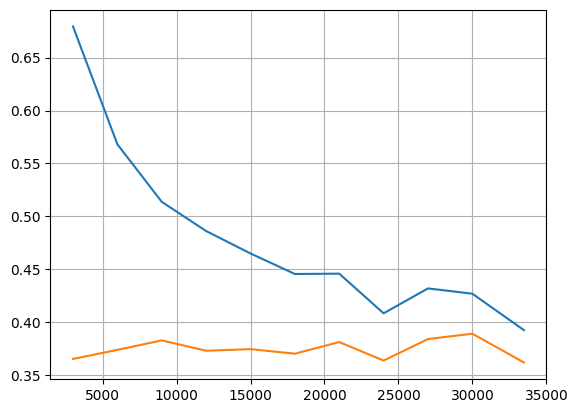

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = 100
hidden_size = 505
num_classes = 3 #Neutral, Positive, Negative
num_epochs = 100
learning_rate = 1e-2
dropout_rate = 0.2

randreset(666)
Xtrain, X1 , Ytrain, Y1 = train_test_split(X, Y, test_size=0.2, random_state=69)
Xval, Xtest , Yval, Ytest = train_test_split(X1, Y1, test_size=0.5, random_state=69)

Xt = torch.tensor(Xtrain, dtype=torch.float, device=device)
Yt = torch.tensor(Ytrain, device=device)

Xv = torch.tensor(Xval, dtype=torch.float, device=device)
Yv = torch.tensor(Yval, device=device)

XT = torch.tensor(Xtest, dtype=torch.float, device=device)
YT = torch.tensor(Ytest, device=device)

Tscores = []
Vscores = []
for size in [3000,6000,9000,12000,15000,18000,21000,24000,27000,30000,33486,]:
    TrainDataset = torch.utils.data.TensorDataset(Xt[:size], Yt[:size])
    TrainDataloader = torch.utils.data.DataLoader(TrainDataset, batch_size=64,shuffle=True)

    randreset(666)       
    model = NeuralNetwork(input_size, hidden_size, num_classes, nn.LeakyReLU, dropout_rate).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adamax(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        train_loss = train(model,TrainDataloader, criterion, optimizer, device) 
    _, Ptrain = torch.max(model(Xt[:size]), 1)
    Ptrain = Ptrain.cpu()
    Ptraintrue = Yt.cpu()
    _, Ptest = torch.max(model(XT), 1)
    Ptest = Ptest.cpu()
    Ptesttrue = YT.cpu()
    Tscores+= [skf1(Ptraintrue[:size], Ptrain, average="weighted")]
    Vscores += [skf1(Ptesttrue, Ptest, average="weighted")]

plt.grid()
plt.plot([3000,6000,9000,12000,15000,18000,21000,24000,27000,30000,33486], Tscores, label="Train Score")
plt.plot([3000,6000,9000,12000,15000,18000,21000,24000,27000,30000,33486], Vscores, label="Test Score")
plt.show()



Function for vectorizing the test_set data,that will be used to evaluate our work

In [17]:
#Vectorize Test_Set Data
def vectorize_test(df, model_name):
    X = []
    model = Word2Vec.load(model_name) 
    for (i, tweet) in enumerate(df['Text'].values):
        featureVec = np.zeros(100,dtype="float32")
        nwords = 0
        #Converting Index2Word which is a list to a set for better speed in the execution.
        index2word_set = set(model.wv.index_to_key)
        for word in word_tokenize(tweet):
            if word in index2word_set:
                nwords = nwords + 1
                featureVec = np.add(featureVec,model.wv[word])
        # Dividing the result by number of words to get average
        if(nwords > 0):
            featureVec = np.divide(featureVec, nwords)
        X.append(featureVec) #we keep the mean 
    return X
X = vectorize_test(test_set,"word2vec.model")
X = torch.tensor(X, requires_grad=True)


Train model with best hyperparameters

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = 100
hidden_size = 505
num_classes = 3 #Neutral, Positive, Negative
num_epochs = 100
learning_rate = 1e-2
dropout_rate = 0.2

model = NeuralNetwork(input_size, hidden_size, num_classes,nn.LeakyReLU, dropout_rate).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adamax(model.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    train_loss = train(model,TrainDataloader, criterion, optimizer, device)

Predictions on Test_set and importing results to cvs file

In [19]:
#Predictions on Test_set and importing results to cvs file
model.eval()
pred = model(X)
_, predlabel = torch.max(pred.data, 1)
predlabel = predlabel.tolist()

predlabel = pd.DataFrame(predlabel)
predlabel.index = np.arange(predlabel.shape[0]) + 1
id = np.arange(predlabel.shape[0]) + 1
id = pd.DataFrame(id)
id.index = id.index + 1

predlabel = pd.concat([id,predlabel], axis=1)
predlabel.columns = ["Id", "Predicted"]
predlabel['Predicted'] = predlabel.Predicted.map({
    0:'POSITIVE',
    1:'NEUTRAL',
    2:'NEGATIVE'   
})
predlabel.to_csv('submission.csv', index= False)


Sourses:
https://towardsdatascience.com/skip-gram-neural-network-from-scratch-485f2e688238
https://radimrehurek.com/gensim/models/word2vec.html
https://www.kaggle.com/code/varun08/sentiment-analysis-using-word2vec
https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-pytorch.md
https://machinelearningmastery.com/activation-functions-in-pytorch/
https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e
https://pytorch.org/docs/stable/generated/torch.no_grad.html
https://optuna.readthedocs.io/en/stable/tutorial/20_recipes/002_multi_objective.html
https://wandb.ai/authors/ayusht/reports/Implementing-Dropout-in-PyTorch-With-Example--VmlldzoxNTgwOTE
https://www.kaggle.com/code/arihant0497/introduction-to-neural-networks-using-pytorch/notebook
https://pythonguides.com/pytorch-batch-normalization/
https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html